These are the variables being used:
- 'label': 0 or 1 (integer; which is SITB_ABSENT or SITB_PRESENT)
- 'reputation' (float between 0 and 1)
- 'contact_size' (float between 0 and 1)

- 'type': categorical, either: 0 (comment), 0.5 (question) or 1 (StatusUpdate)
- 'tag': list of strings, e.g., ['health', 'veterans', 'affairs', 'benefits' , 'military', 'family' , 'veterans', 'health', 'administration']

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scattertext import SampleCorpora, PhraseMachinePhrases, dense_rank, RankDifference, AssociationCompactor, produce_scattertext_explorer
from scattertext.CorpusFromPandas import CorpusFromPandas
import scattertext as st

on_google_drive = False

if on_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    input_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/input/'
    output_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/output/'
else:
    input_dir = './data/input/final_datasets/'
    output_dir = './data/output/semantic_analysis/'
    

/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train = pd.read_csv(input_dir + 'train.csv')

In [8]:
train_metadata = train[['label', 'reputation', 'contact_size', 'type', 'tags']]
train_metadata

,label,reputation,contact_size,type,tags
0,0.0,0.000047,0.000344,0.0,"[""donald trump""]"
1,0.0,0.167313,0.081946,0.0,"[""ptsd"",""substance use"",""victory for veterans""]"
2,1.0,0.000000,0.000000,0.0,NaN
3,0.0,0.000450,0.001375,0.0,"[""marriage"",""children"",""ptsd"",""service""]"
4,0.0,0.024174,0.014190,0.0,"[""command post"",""jumpmaster instructor"",""82nd ..."
...,...,...,...,...,...
6473,0.0,0.021059,0.046939,0.0,"[""world history"",""american history"",""food chow..."
6474,0.0,0.000000,0.000000,0.0,NaN
6475,0.0,0.000041,0.000638,0.0,"[""realtor"",""real estate"",""transition""]"
6476,0.0,0.042655,0.005450,0.0,"[""humor""]"


In [14]:
train['type'].unique()

array([0. , 1. , 0.5])

In [25]:
type_map = {0: 'comment',
            0.5: 'question', 
            1: 'status update'}

label_map = {0: 'Nonsuicidal',
            1: 'Suicidal'}

train_metadata['type'] = train['type'].map(type_map)
train_metadata['label'] = train['label'].map(label_map)

type_stats = train_metadata.groupby('label')['type'].value_counts(normalize=True)
type_stats
# display(train_metadata.groupby('label')['type'].value_counts(normalize=True))


/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


label        type         
Nonsuicidal  comment          0.859099
             status update    0.092792
             question         0.048108
Suicidal     comment          0.913658
             question         0.045526
             status update    0.040816
Name: type, dtype: float64

label
Nonsuicidal    AxesSubplot(0.125,0.11;0.775x0.77)
Suicidal       AxesSubplot(0.125,0.11;0.775x0.77)
Name: contact_size, dtype: object

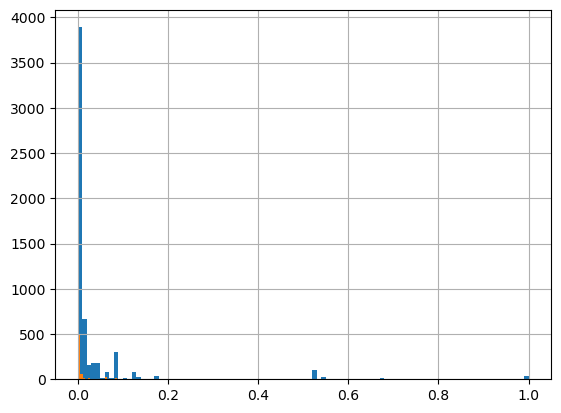

In [29]:
type_map = {0: 'comment',
            0.5: 'question', 
            1: 'status update'}


train_metadata.groupby('label')['contact_size'].hist(bins=100)
# type_stats = train_metadata.groupby('label')['type'].value_counts(normalize=True)
# type_stats
# display(train_metadata.groupby('label')['type'].value_counts(normalize=True))


<AxesSubplot:xlabel='label,tags'>

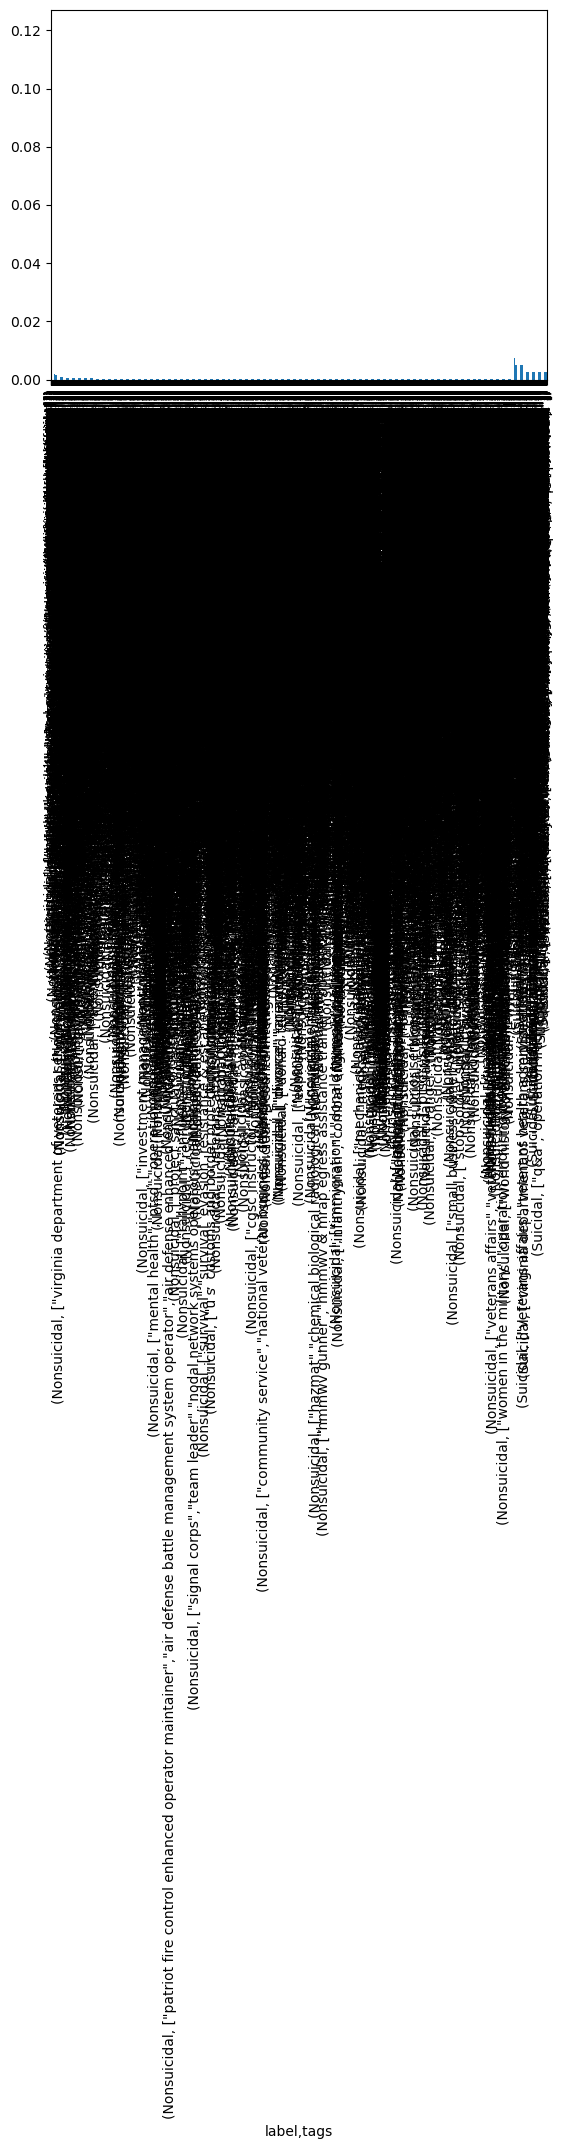

In [32]:
type_stats = train_metadata.groupby('label')['tags'].value_counts(normalize=True)
type_stats.plot(kind='bar')